In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mpl_config
import ode_models as odes

### Set up and solve ODE model

In [2]:
alpha = 1.5
beta = 1
delta = 1
gamma = 3
x0 = 1
y0 = 1
t = np.linspace(0, 20, 500)
X0 = [x0, y0]

lotkavolterra = odes.LotkaVolterra([alpha, beta, delta, gamma])
solution = lotkavolterra.solve(initial_conditions=X0, timepoints=t)

### Plot ODE solution

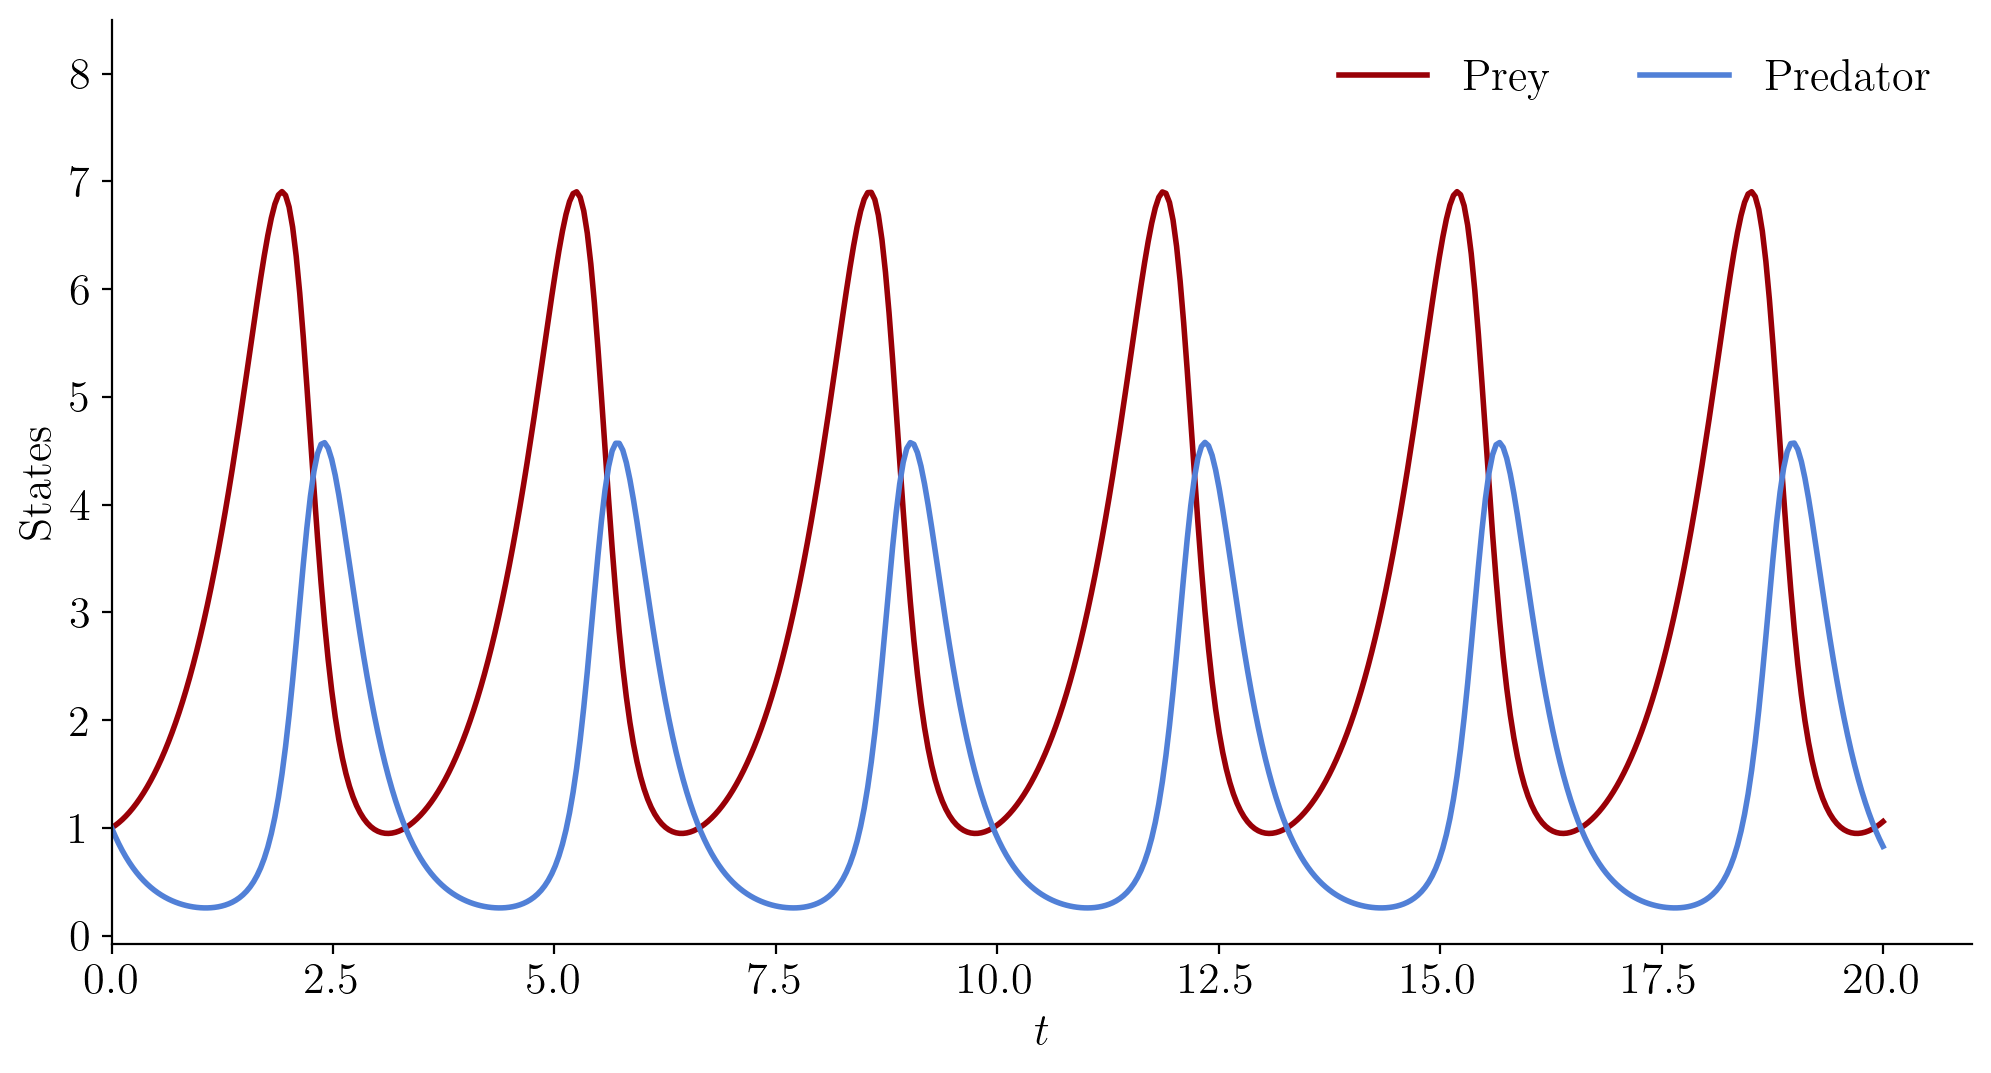

In [3]:
_, ax = lotkavolterra.plot(t, solution, ls="-")
ax.set_ylim(top=8.5)
ax.legend(loc="upper right", ncol=2)
plt.show()

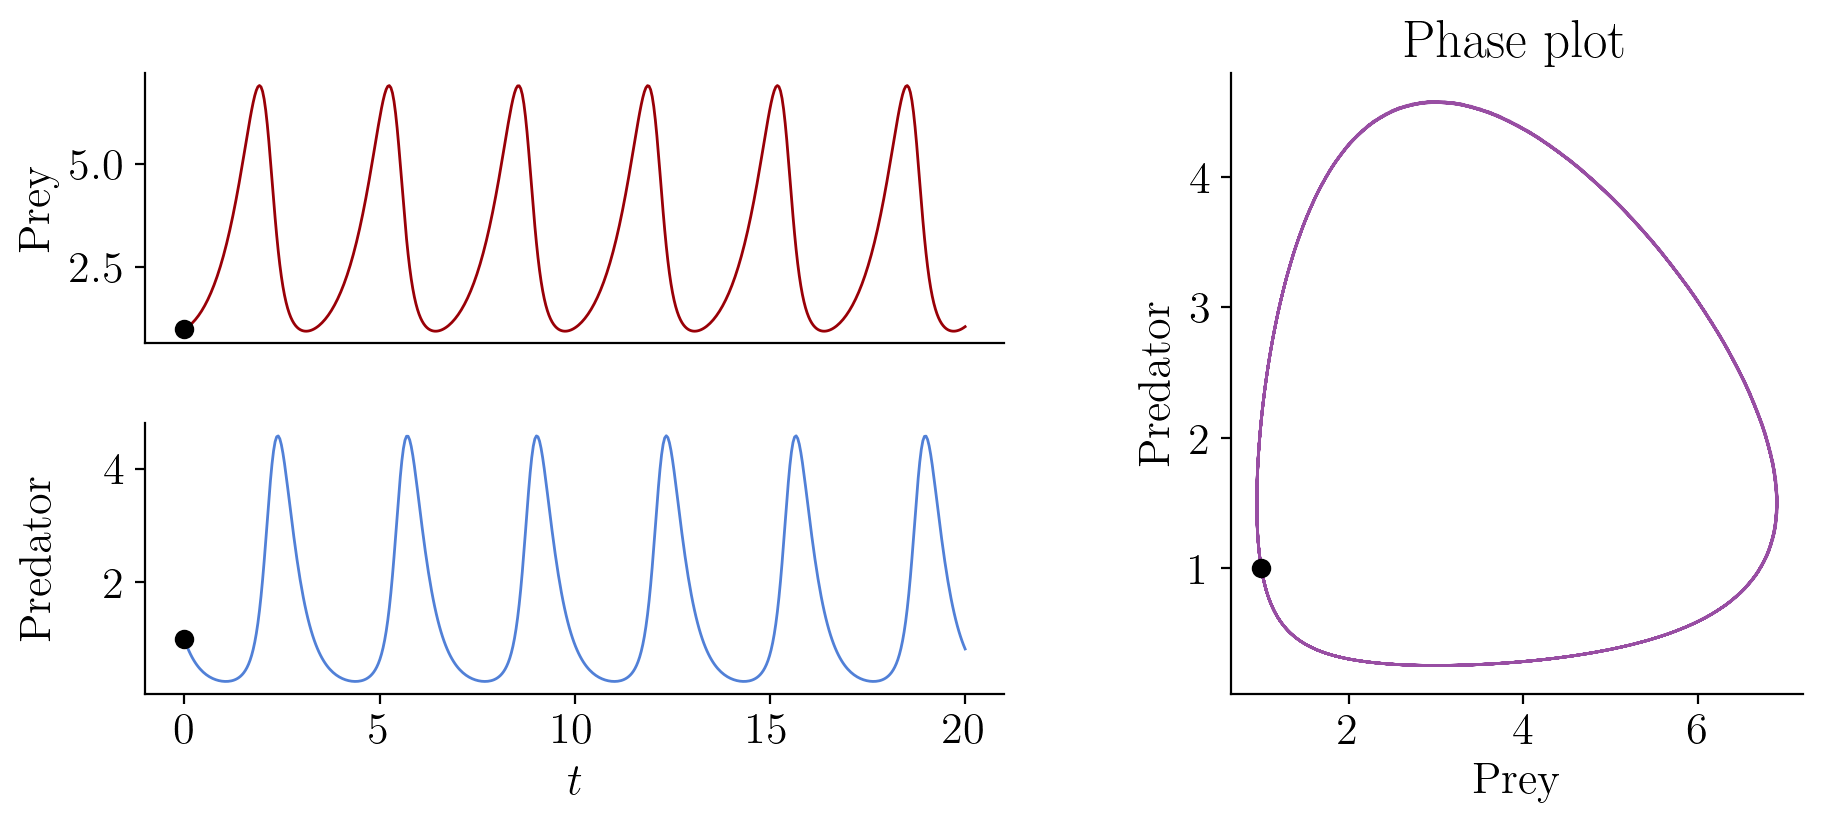

In [4]:
lotkavolterra.plot_phase(t, solution)
plt.show()

### Plot noised solutions

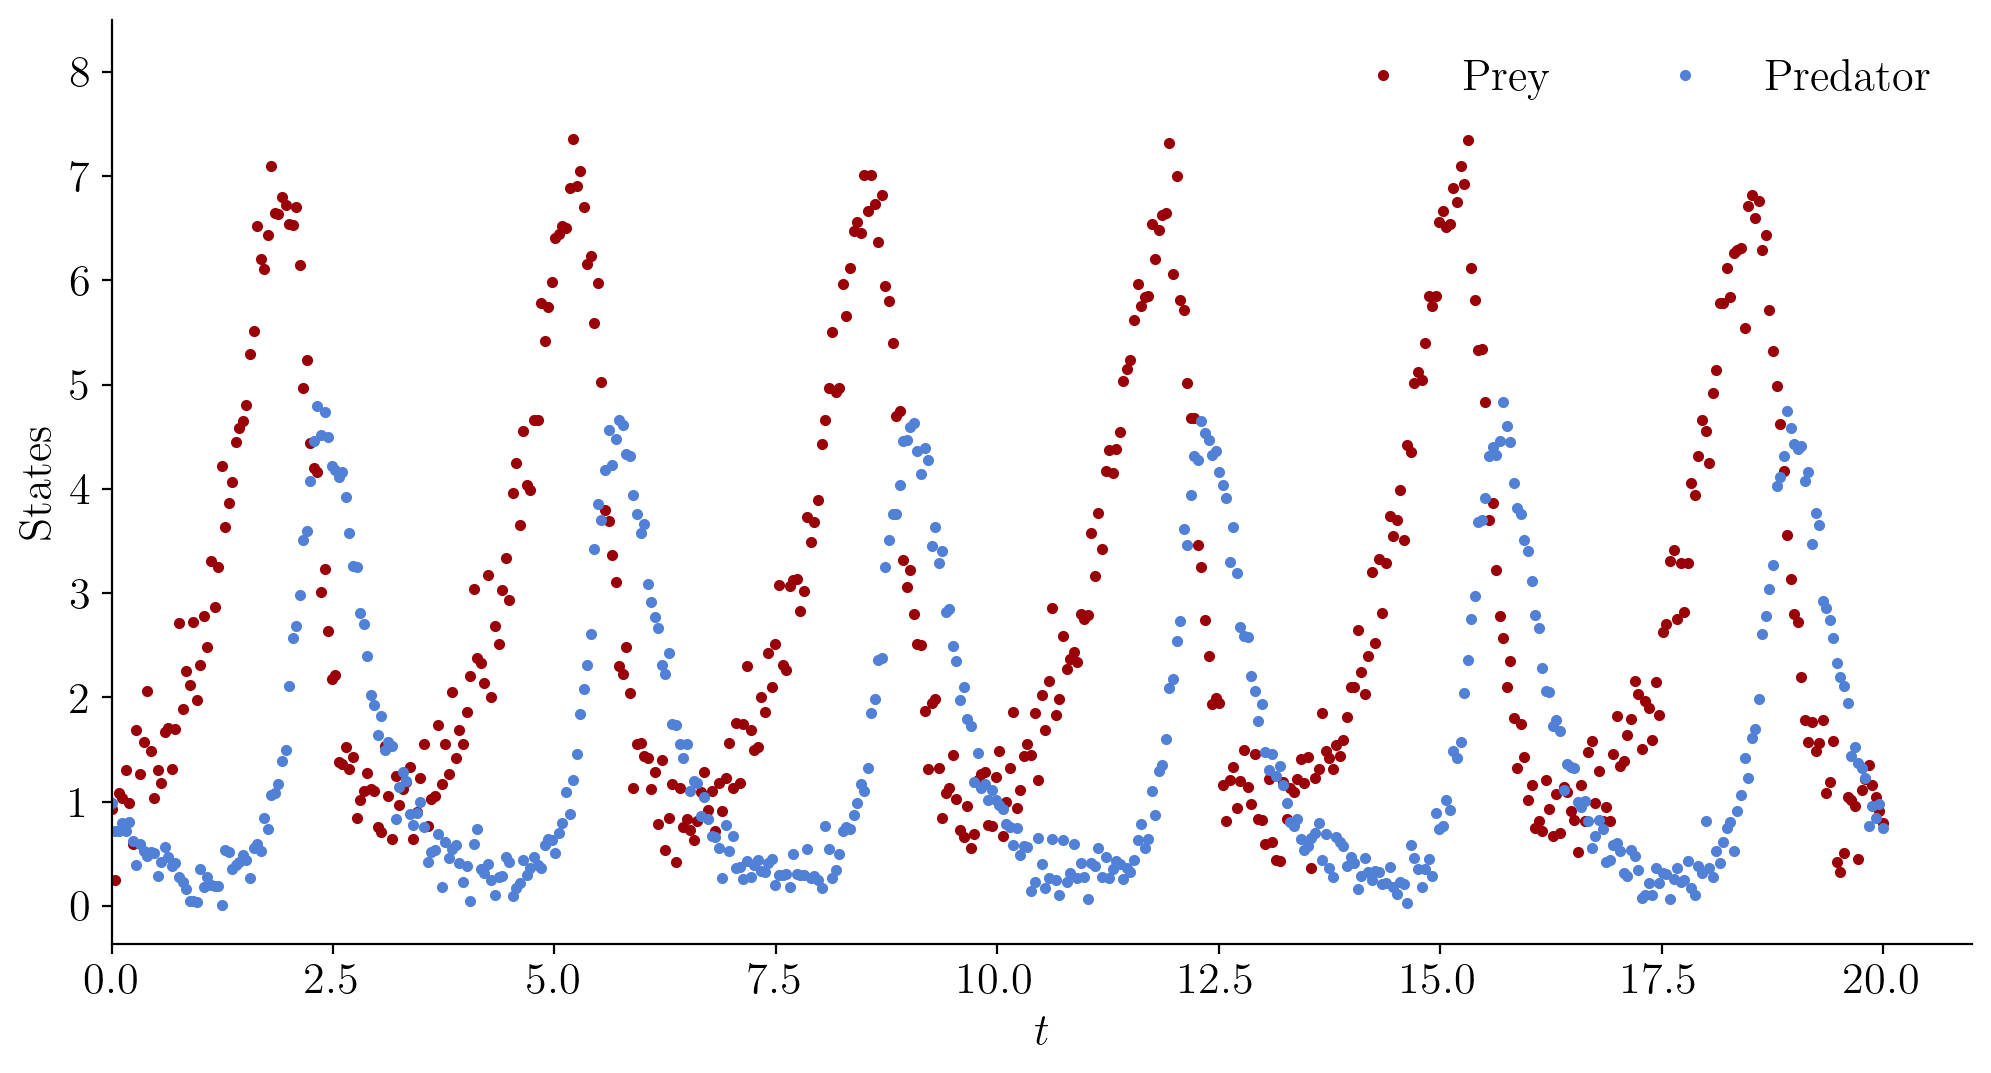

In [5]:
_, ax = lotkavolterra.plot(t, lotkavolterra.noise(solution, 0.10))
ax.set_ylim(top=8.5)
ax.legend(loc="upper right", ncol=2)
plt.show()

In [26]:
import gpytorch
import torch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ZeroMean
from gpytorch.kernels import ScaleKernel, RBFKernel 

class ExactGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood,
                 constant_bounds=None, length_scale_bounds=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ZeroMean()
        if constant_bounds and length_scale_bounds:
            self.covar_module = ScaleKernel(
                RBFKernel(lengthscale_constraint=gpytorch.constraints.Interval(*length_scale_bounds)),
                outputscale_constraint=gpytorch.constraints.Interval(*constant_bounds)
            )
        else:
            self.covar_module = ScaleKernel(RBFKernel())
            
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
def train(model, likelihood, train_x, train_y, training_iter=50):
    # Set into training mode
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Train over several iterations using the full training dataset each time
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #     i + 1, training_iter, loss.item(),
        #     model.covar_module.base_kernel.lengthscale.item(),
        #     model.likelihood.noise.item()
        # ))
        optimizer.step()

In [27]:
predator, prey = torch.from_numpy(solution[0]).float(), torch.from_numpy(solution[1]).float()
t = torch.from_numpy(t)

TypeError: expected np.ndarray (got Tensor)

In [28]:
# Assuming time_domains_sampled[0] and snapshots_sampled[0] are numpy arrays
likelihood = GaussianLikelihood()
# Convert numpy arrays to float32 tensors:

torch_gp = ExactGPModel(
    t, predator, likelihood,
)

train(torch_gp, likelihood, t, predator, training_iter=1000)

In [29]:
torch_gp.eval()
with torch.no_grad():
    # Convert to float32
    y = torch_gp(t)
    ly = likelihood(y)
    mean_ly = ly.mean
    std_ly = ly.stddev

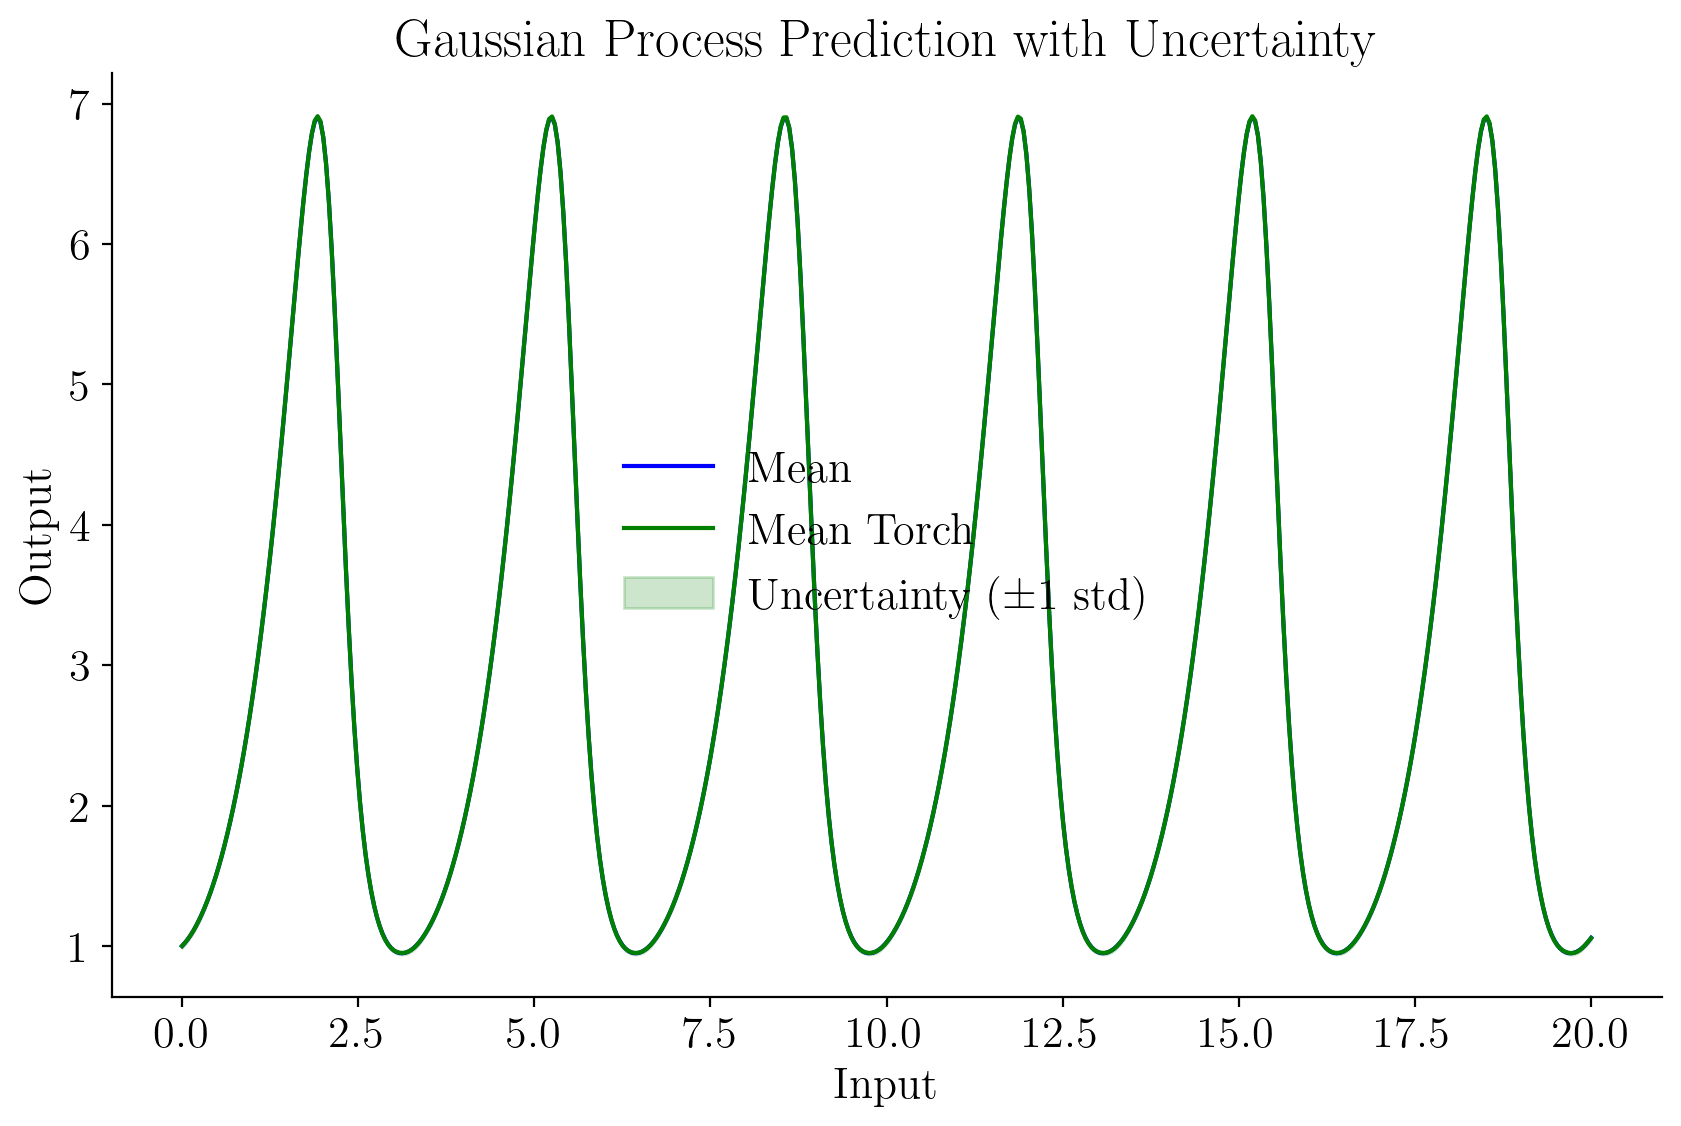

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(t, predator, 'b-', label='Mean')
plt.plot(t, mean_ly, 'g-', label='Mean Torch')
plt.fill_between(t, mean_ly - std_ly, mean_ly + std_ly, color='green', alpha=.2, label='Uncertainty (±1 std)')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Gaussian Process Prediction with Uncertainty')
plt.legend()
plt.show()